<a href="https://colab.research.google.com/github/cagBRT/timeSeries/blob/main/2_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By the end of this notebook the student will be able to:<br>
1. Create a synthetic time series 
2. Split the data into test and train sets
3. Perform a Naive forecast
4. Perform a Rolling Average forecast

This notebook creates a time series and forecasts using
- Naive Forecasting<br>
- Moving Average Forecasting<br>
The performance of each is compared using Mean Squared Error and Mean Absolute Error





**Import the necessary libraries**

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

The next code blocks will set up the time series with seasonality, trend and some noise. 

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

**Define Constants**

In [5]:
period = 365
time = np.arange(50 * period + 1, dtype="float32")
#baseline = 10
baseline=5
series = trend(time, 0.1)  
amplitude = 40
slope = 0.05
noise_level = 5

**Create the timeseries data and add noise**<br>
A time series has three components: <br>
- the baseline<br>
- trend<br>
- seasonality

In [10]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

**Plot the series**

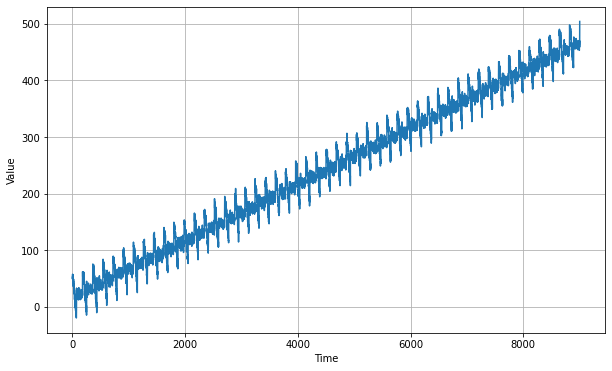

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

**Split the series**<br>
Into train and test sets so we can start forecasting.<br>
Time 0 - 1000 will be for training the model and 1001 to the end of the time series will be used to test the model.

In [12]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

**Plot the training series**

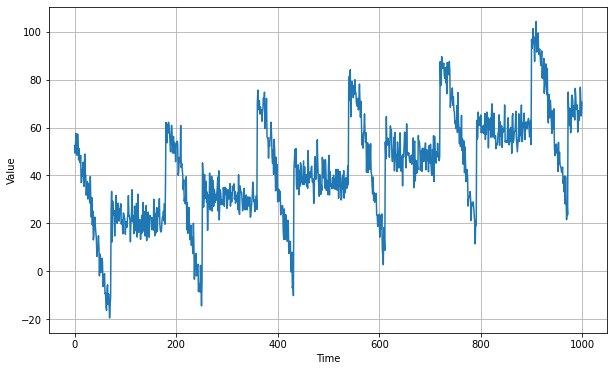

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

**Plot the test data**

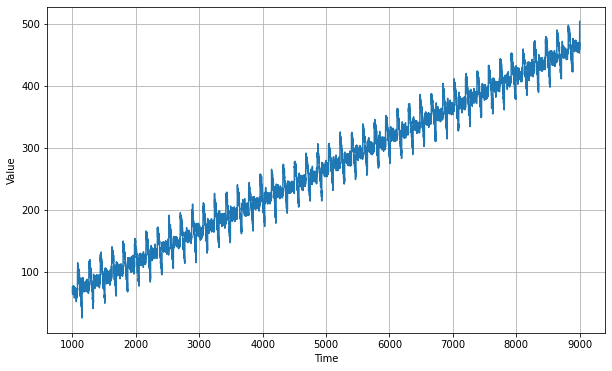

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast

It is useful to test simple forecast strategies prior to testing more complex models.<br>

Simple forecast strategies are those that assume little or nothing about the nature of the forecast problem and are fast to implement and calculate.<br>

The results can be used as a baseline in performance and used as a point of a comparison. If a model can perform better than the performance of a simple forecast strategy, then it can be said to be skillful.<br>

There are two main themes to simple forecast strategies; they are:<br>

- Naive, or using observations values directly.
- Average, or using a statistic calculated on previous observations.

**Simple example of Naive Forecasting**<br>
A naive forecast involves using the previous observation directly as the forecast without any change.<br><br>
It is often called the persistence forecast as the prior observation is persisted.<br><br>
This simple approach can be adjusted slightly for seasonal data. In this case, the observation at the same time in the previous cycle may be persisted instead.
<br><br>

For example, given the series:<br>
>[1, 2, 3, 4, 5, 6, 7, 8, 9]<br>
We could persist the last observation (relative index -1) as the value 9 or persist the second last prior observation (relative index -2) as 8, and so on.



In [15]:
naive_forecast = series[split_time - 1:-1]

**Plot the series and the forecast**<br>
The series is plotted in blue<br>
The forecast is plotted in orange.

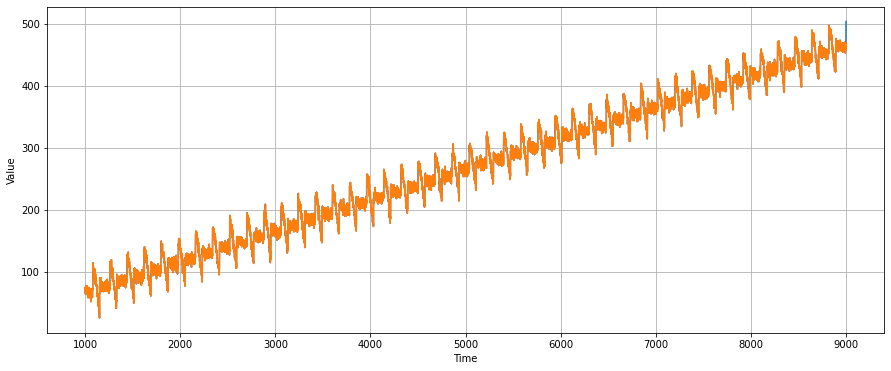

In [18]:
plt.figure(figsize=(15, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Zoom in on the start of the validation period. <br>
You can see that the naive forecast lags 1 step behind the time series.

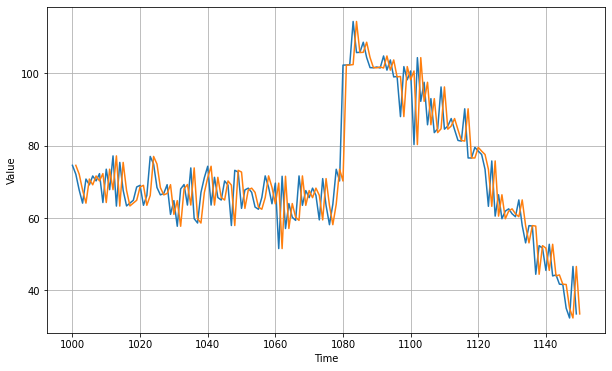

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [20]:
mse = keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
print("Mean Squared Error = ", mse)
print("Mean Absolute Error = ", mae)

Mean Squared Error =  70.427895
Mean Absolute Error =  6.17042


That's the baseline for our timeseries. <br>
Now try the moving average forecast

#Average Forecast<br>


All prior observations are collected and averaged, either using the mean or the median, with no other treatment to the data.<br>

In some cases, we may want to shorten the history used in the average calculation to the last few observations.<br>

We can generalize this to the case of testing each possible set of n-prior observations to be included into the average calculation.<br>

>For example, given the series:<br>
[1, 2, 3, 4, 5, 6, 7, 8, 9]<br>
We could average the last one observation (9), the last two observations (8, 9), and so on.<br>

In the case of seasonal data, we may want to average the last n-prior observations at the same time in the cycle as the time that is being forecasted.
<br>
>For example, given the series with a 3-step cycle:<br>
[1, 2, 3, 1, 2, 3, 1, 2, 3]<br>
We could use a window size of 3 and average the last one observation (-3 or 1),<br> the last two observations (-3 or 1, and -(3 * 2) or 1), and so on.



In [21]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

**Plot the series and the average forecast**<br>
The series is plotted in blue<br>
The forecast is plotted in orange.

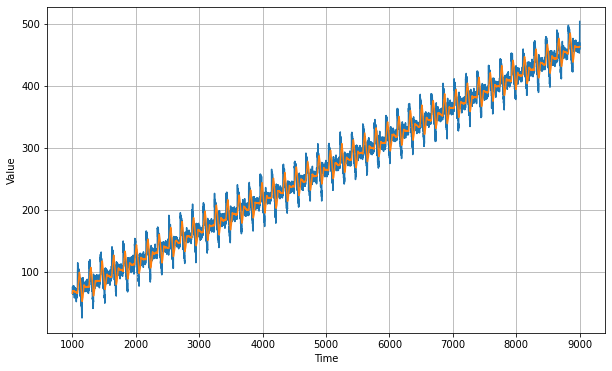

In [22]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

Looking at this forecast, do you think the MSE and the MAE are going to worse or better than the Naive forecast?

In [23]:
mse = keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
print("Mean squared error = ", mse)
print("Mean absolute error = ", mae)

Mean squared error =  233.91267
Mean absolute error =  11.760496


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing.<br>
 Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

**Difference the time series to remove seasonality**

In [24]:
diff_series = (series[period:] - series[:-period])
diff_time = time[period:]

Plot the differenced time series

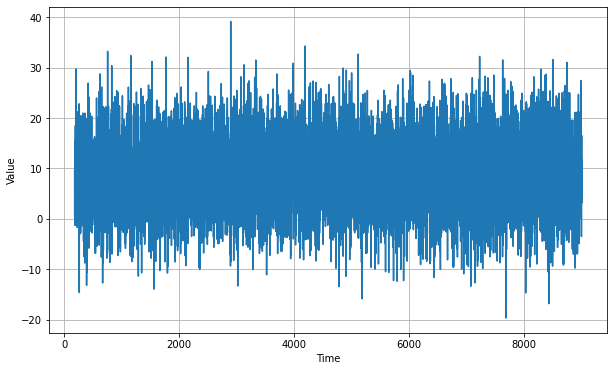

In [25]:
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

The trend and seasonality seem to be gone, so use the moving average:

In [26]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - period - 50:]

**Plot the time series an the differenced moving average forecast**<br>
Timeseries is blue<br>
Differenced Average Forecast is orange

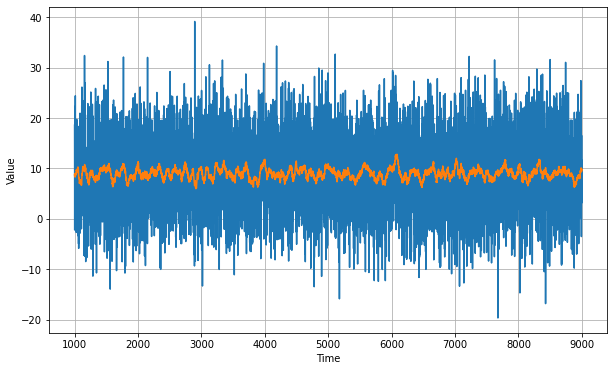

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - period:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

In [28]:
diff_moving_avg_plus_past = series[split_time - period:-period] + diff_moving_avg

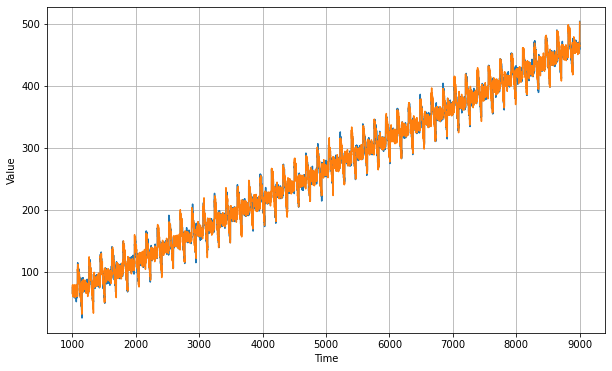

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [30]:
mse = keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()
print("Mean squared error = ", mse)
print("Mean absolute error = ", mae)

Mean squared error =  51.876728
Mean absolute error =  5.7538924


The result is better than the naive forecast. <br>
However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving average on past values to remove some of the noise:

In [31]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - (period+5):-(period-5)], 10)\
+ diff_moving_avg

**Plot the moving series and the moving average without the noise**

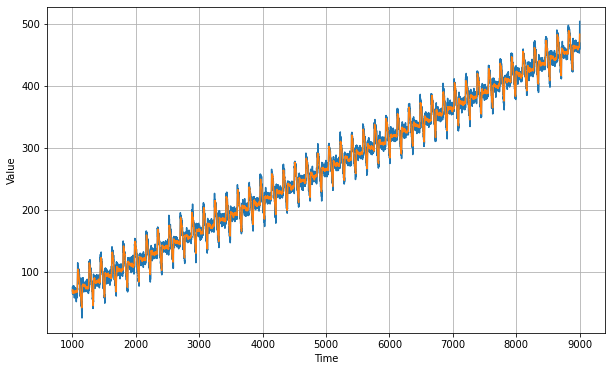

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [33]:
mse = keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()
print("Mean square error = ", mse)
print("Mean absolute error = ", mae)

Mean square error =  44.155315
Mean absolute error =  4.9963


# **Assignment**<br>
1. Change the synthetic timeseries by first changing just the baseline. Does this change the error rates?<br>
2. Change the number of periods. Right now it is 4, try more periods and less periods, what does that do to the forecast. You may need to change the test and training periods also.
